In [1]:
## Importing needed packages

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import astropy.units as u
from astropy.utils.data import download_file
from astropy.io import fits  # We use fits to open the actual data file

from astropy.utils import data

#For plotting Gaussian
from scipy.optimize import curve_fit
from astropy import modeling
from scipy.stats import norm
import math
import seaborn as sns
from scipy.signal import find_peaks
import scipy.stats as stats
import scipy.stats
from scipy import ndimage




In [2]:
location = "/Users/RuheeJanmohamed/Desktop/Data/co_zero_north.fits"

hdul = fits.open(location)

hdu_zero_north = hdul[0]

co_zero_north = hdu_zero_north.data

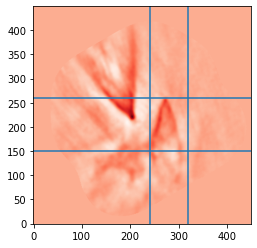

In [259]:
im_rot = ndimage.rotate(co_zero_north, angle=-30,reshape=False)

plt.imshow(im_rot,cmap='Reds',origin='lower')

plt.axvline(240) 
plt.axvline(320) 
plt.axhline(260)
plt.axhline(150)

[4990.53194871  259.04754415    5.72297483 2643.19339941  285.0714004
    8.69925824]


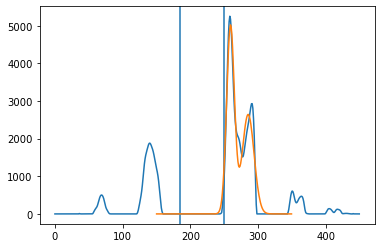

In [270]:
#Fitting Gausian to one curve first

cut = im_rot[200:210,:] 
cut[cut<0]=0
avg_cut = np.mean(cut,axis=0)

plt.plot(range(450),avg_cut)


#Defining Double Gaussian

def Double_Gauss(x,amp_1,mean_1,sigma_1,amp_2,mean_2,sigma_2):
    f = (amp_1 * np.exp(-(x - mean_1)**2/(2*sigma_1**2))+ amp_2 * np.exp(-(x-mean_2)**2/(2*sigma_2**2)))
    return f

xdata=np.arange(150,350)
ydata=avg_cut[150:350]

plt.axvline(185) 
plt.axvline(250)
p0 = (np.max(ydata),xdata[np.argmax(ydata)],5,np.max(ydata),xdata[np.argmax(ydata)]+15,5)


p_opt,p_cov = curve_fit(Double_Gauss,xdata,ydata,p0)
plt.plot(xdata,Double_Gauss(xdata,p_opt[0],p_opt[1],p_opt[2],p_opt[3],p_opt[4],p_opt[5]))
print(p_opt)




In [271]:
ycut_list = [(150+((i)*5),150+((i+1)*5)) for i in range(20)] #starting at the widest part and work towards star

print(ycut_list)

[(150, 155), (155, 160), (160, 165), (165, 170), (170, 175), (175, 180), (180, 185), (185, 190), (190, 195), (195, 200), (200, 205), (205, 210), (210, 215), (215, 220), (220, 225), (225, 230), (230, 235), (235, 240), (240, 245), (245, 250)]


(2197.9566274543413, 145, 5, 2197.9566274543413, 205, 5)


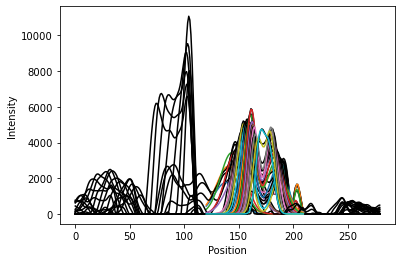

In [279]:
Model_Values = open("NorthSecond(DG)_Model_Values.txt", "w")

# Model_Values.write("Left Hand Gaussian \n")
Model_Values.write("y_cut\tfit_pk_1\tfit_x_1\tfit_s_1\tfit_pk_2\tfit_x_2\tfit_s_2\tfit_pk_e\tfit_x_e\tfit_s_e\tx_c1\tx_c2\tpk_c1\tpk_c2\n")

offset_x1 = 100 #200
offset_x2 = 380

first = 0

for ycut in ycut_list:
    cut = im_rot[ycut[0]:ycut[1],offset_x1:offset_x2]
    avg_cut = np.mean(cut,axis=0)
    avg_cut[avg_cut<0]=0 #doesn't change original image
    xdata=np.arange(120,210)
    idata=avg_cut[120:210] #110:180
    
    if (first < 1): #giving it intial first guess
        p0 = (np.max(idata),xdata[np.argmax(idata)],5,np.max(idata),xdata[np.argmax(idata)]+60,5)
        first =1
        print(p0)
    else:
        p0 = p_opt #telling it to look where it was before
        
    p_opt,p_cov = curve_fit(Double_Gauss,xdata,idata,p0,maxfev=9000)
    
       
    
    plt.plot(range(280),avg_cut,c='k')
    plt.plot(xdata,Double_Gauss(xdata,p_opt[0],p_opt[1],p_opt[2],p_opt[3],p_opt[4],p_opt[5]))
    
    Err =np.sqrt(np.diag(p_cov))
    Model_Values.write("%f\t" % np.mean(ycut)) #,0.
    Model_Values.write("%f\t%f\t%f\t\t%f\t\t%f\t\t%f\t\t" % (p_opt[0],p_opt[1]+offset_x1,p_opt[2],p_opt[3],p_opt[4]+offset_x1,p_opt[5]))
    Model_Values.write("%f\t%f\t%f\t%f\t%f\t%f\t" % (Err[0],Err[1],Err[2],Err[3],Err[4],Err[5]))
    Model_Values.write("%f\t%f\t" % (xdata[idata==np.max(idata)]+offset_x1,xdata[np.argmax(idata)]+offset_x1))
    Model_Values.write("%f\t" % (np.max(idata)))
    Model_Values.write("\n")
 

plt.xlabel("Position")
plt.ylabel("Intensity")
Model_Values.close()




In [280]:
ycut_right,xfit_right = np.genfromtxt("NorthSecond(DG)_Model_Values.txt", skip_header = 2, unpack=True, usecols=[0,2])
ycut_left,xfit_left = np.genfromtxt("NorthSecond(DG)_Model_Values.txt", skip_header = 2, unpack=True, usecols=[0,5])

print(xfit_right)
print(xfit_left)

[240.714418 243.344432 247.066149 253.648335 246.757165 252.8347
 253.85027  254.673587 256.569412 258.482319 259.484836 260.574554
 261.368822 262.01752  262.926122 263.953201 264.923436 267.422112
 268.819981]
[303.467676 303.170628 302.074533 299.736554 260.383382 278.235297
 286.286982 288.557474 288.081003 286.095042 283.802621 283.838142
 282.794918 281.617364 280.71702  280.212774 279.390019 278.715792
 277.092687]


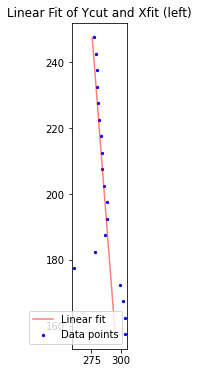

-0.21682268315789402


In [281]:
fit = np.polyfit(ycut_left, xfit_left,1)
ang_coeff = fit[0]
intercept = fit[1]
fit_eq = ang_coeff*ycut_left + intercept

fig = plt.figure(figsize=[1,6])
ax = fig.subplots()
ax.plot(fit_eq,ycut_left,color = 'r', alpha = 0.5, label = 'Linear fit')
ax.scatter(xfit_left, ycut_left,s = 5, color = 'b', label = 'Data points') #Original data points
ax.set_title('Linear Fit of Ycut and Xfit (left)')
ax.legend()
plt.show()

print(ang_coeff)

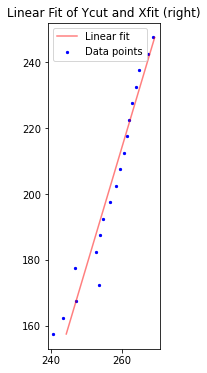

0.2762283477192985


In [282]:
fit = np.polyfit(ycut_right, xfit_right,1)
ang_coeff = fit[0]
intercept = fit[1]
fit_eq = ang_coeff*ycut_right + intercept

fig = plt.figure(figsize=[2,6])
ax = fig.subplots()
ax.plot(fit_eq,ycut_right,color = 'r', alpha = 0.5, label = 'Linear fit')
ax.scatter(xfit_right, ycut_right,s = 5, color = 'b', label = 'Data points') #Original data points
ax.set_title('Linear Fit of Ycut and Xfit (right)')
ax.legend()
plt.show()

print(ang_coeff)

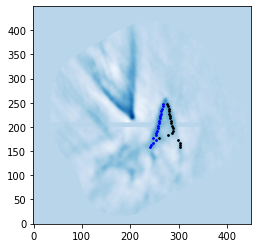

In [283]:
plt.imshow(im_rot,cmap='Blues',origin='lower')
plt.scatter(xfit_left,ycut_left, s=3, c='k')
plt.scatter(xfit_right,ycut_right, s=3, c='b')